In [240]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import warnings
import dtale

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')
sns.set(context="notebook", 
        palette="Set1", 
        style = 'darkgrid' ,
        color_codes=True)
%matplotlib inline

In [158]:
diamond_rd = pd.read_csv('bluenile_diamonds_round.csv')
diamond_ov_cu = pd.read_csv('bluenile_diamonds_ov-cu.csv')
diamond_df = pd.concat([diamond_rd, diamond_ov_cu])
diamond_df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
diamond_df.head()

,id,detailsPageUrl,carat,date,dateSet,price,strikethroughPrice,pricePerCarat,shapeName,clarity,color,culet,cut,depth,fluorescence,lxwRatio,polish,symmetry,table,measurements
0,LD13346514,./diamond-details/LD13346514,['5.01'],['Jun 24'],['Jun 25'],"['$42,001']",NaN,"['$8,383']",['Round'],['SI2'],['K'],['None'],Good,['65.2'],['Strong'],['1.00'],['Excellent'],['Very Good'],['54.0'],10.57 x 10.55 x 6.88 mm
1,LD12736875,./diamond-details/LD12736875,['4.63'],['Jun 24'],['Jun 25'],"['$41,019']",NaN,"['$8,859']",['Round'],['SI2'],['K'],['Small'],Good,['54.7'],['Strong'],['1.01'],['Good'],['Good'],['64.0'],11.06 x 11.19 x 6.09 mm
2,LD13529002,./diamond-details/LD13529002,['2.01'],['Jul 24'],['Jul 27'],"['$7,731']",NaN,"['$3,846']",['Round'],['SI2'],['K'],['None'],Good,['66.0'],['None'],['1.01'],['Very Good'],['Very Good'],['56.0'],7.79 x 7.69 x 5.11 mm
3,LD12736893,./diamond-details/LD12736893,['1.65'],['Jun 24'],['Jun 25'],"['$6,755']",NaN,"['$4,094']",['Round'],['SI2'],['K'],['Very Small'],Good,['59.8'],['Medium'],['1.00'],['Good'],['Good'],['52.0'],7.71 x 7.73 x 4.62 mm
4,LD13814136,./diamond-details/LD13814136,['1.67'],['Jun 24'],['Jun 25'],"['$6,156']",NaN,"['$3,686']",['Round'],['SI2'],['K'],['None'],Good,['65.4'],['Medium'],['1.01'],['Very Good'],['Very Good'],['59.0'],7.34 x 7.38 x 4.81 mm


In [159]:
diamond_df = diamond_df.drop(['strikethroughPrice'],axis=1)

In [160]:
float_cols = ['carat', 'price', 'pricePerCarat', 'depth', 'lxwRatio', 'table']
for col in float_cols:
    if col is 'price' or col is 'pricePerCarat':
        diamond_df[col] = diamond_df[col].replace(regex={'\$': '', ',': ''})
        diamond_df[col] = diamond_df[col].str.strip('[\'\']').astype(float)
    else:
        diamond_df[col] = diamond_df[col].str.strip('[\'\']').astype(float)

In [161]:
for col in diamond_df.columns:
    if col not in float_cols:
        diamond_df[col] = diamond_df[col].str.strip('[\'\']')

In [162]:
diamond_df['measurements'] = diamond_df['measurements'].str.strip('mm')
diamond_df[['measurements', 'width', 'height']] = diamond_df['measurements'].str.split('x', expand=True).astype(float)
diamond_df.rename(columns={'measurements': 'length', 
                           'depth': 'depth%', 
                           'table': 'table%'}, inplace=True)

In [163]:
diamond_brilliant = pd.read_csv('brilliant_diamonds_rd-ov-cu.csv')
diamond_brilliant.head()

,carat,price,shapeName,clarity,origin,color,culet,cut,depth%,fluorescence,lxwRatio,polish,symmetry,table%,length,width,height,pricePerCarat
0,1.00,2630,Round,SI2,Botswana Sort,J,Pointed,Fair,67.3,Faint,1.0,Very Good,Very Good,58.0,6.12,6.02,4.09,2630.000000
1,1.00,2960,Round,SI2,Russia,J,None,Fair,66.9,None,1.0,Excellent,Good,59.0,6.10,6.04,4.06,2960.000000
2,1.00,3010,Round,SI2,Botswana Sort,J,None,Fair,69.7,None,1.0,Excellent,Very Good,56.0,6.01,5.99,4.18,3010.000000
3,1.02,3110,Round,SI2,Botswana Sort,J,None,Fair,70.3,Faint,1.0,Very Good,Very Good,59.0,5.99,5.93,4.19,3049.019608
4,1.01,3150,Round,SI2,Botswana Sort,J,None,Fair,69.9,Faint,1.0,Very Good,Very Good,58.0,6.00,5.94,4.17,3118.811881


In [164]:
diamond_df = pd.concat([diamond_df, diamond_brilliant])

In [165]:
d = dtale.show(diamond_df, ignore_duplicate=True)
d

In [166]:
diamond_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131549 entries, 0 to 47980
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              83568 non-null   object 
 1   detailsPageUrl  83568 non-null   object 
 2   carat           131549 non-null  float64
 3   date            83568 non-null   object 
 4   dateSet         83568 non-null   object 
 5   price           131549 non-null  float64
 6   pricePerCarat   131549 non-null  float64
 7   shapeName       131549 non-null  object 
 8   clarity         131549 non-null  object 
 9   color           131549 non-null  object 
 10  culet           131250 non-null  object 
 11  cut             131549 non-null  object 
 12  depth%          131549 non-null  float64
 13  fluorescence    131528 non-null  object 
 14  lxwRatio        131549 non-null  float64
 15  polish          131549 non-null  object 
 16  symmetry        131549 non-null  object 
 17  table%     

<img src="files/diamond_shapes-1024x506.jpg" width=40% height=auto>



<img src="files/diamond-clarity-scale.png" width=40% height=auto>


<img src="files/diamond-color-scale.webp" width=50% height=auto>


<img src="files/side_dimensions.jpg" width=20% height=auto>
<img src="files/top_dimensions.jpg" width=20% height=auto>


In [170]:
diamond_df.describe()

,carat,price,pricePerCarat,depth%,lxwRatio,table%,length,width,height
count,131549.000000,1.315490e+05,131549.000000,131549.000000,131549.000000,131549.000000,131549.000000,131549.000000,131549.000000
mean,0.931217,6.654813e+03,4706.888731,62.593507,1.042809,58.232931,6.051990,5.821978,3.647891
std,0.732265,2.223962e+04,3854.731736,2.588896,0.115943,2.232120,1.403334,1.229331,0.774271
min,0.230000,2.420000e+02,803.000000,52.600000,1.000000,48.000000,3.730000,3.320000,0.170000
25%,0.500000,1.193000e+03,2580.000000,61.600000,1.000000,57.000000,5.030000,4.910000,3.080000
50%,0.750000,2.770000e+03,3692.000000,62.500000,1.010000,58.000000,5.910000,5.670000,3.570000
75%,1.080000,6.403000e+03,5693.333333,63.200000,1.010000,59.000000,6.710000,6.480000,4.040000
max,20.980000,2.325535e+06,137769.000000,629.000000,2.180000,69.000000,20.970000,17.840000,10.900000


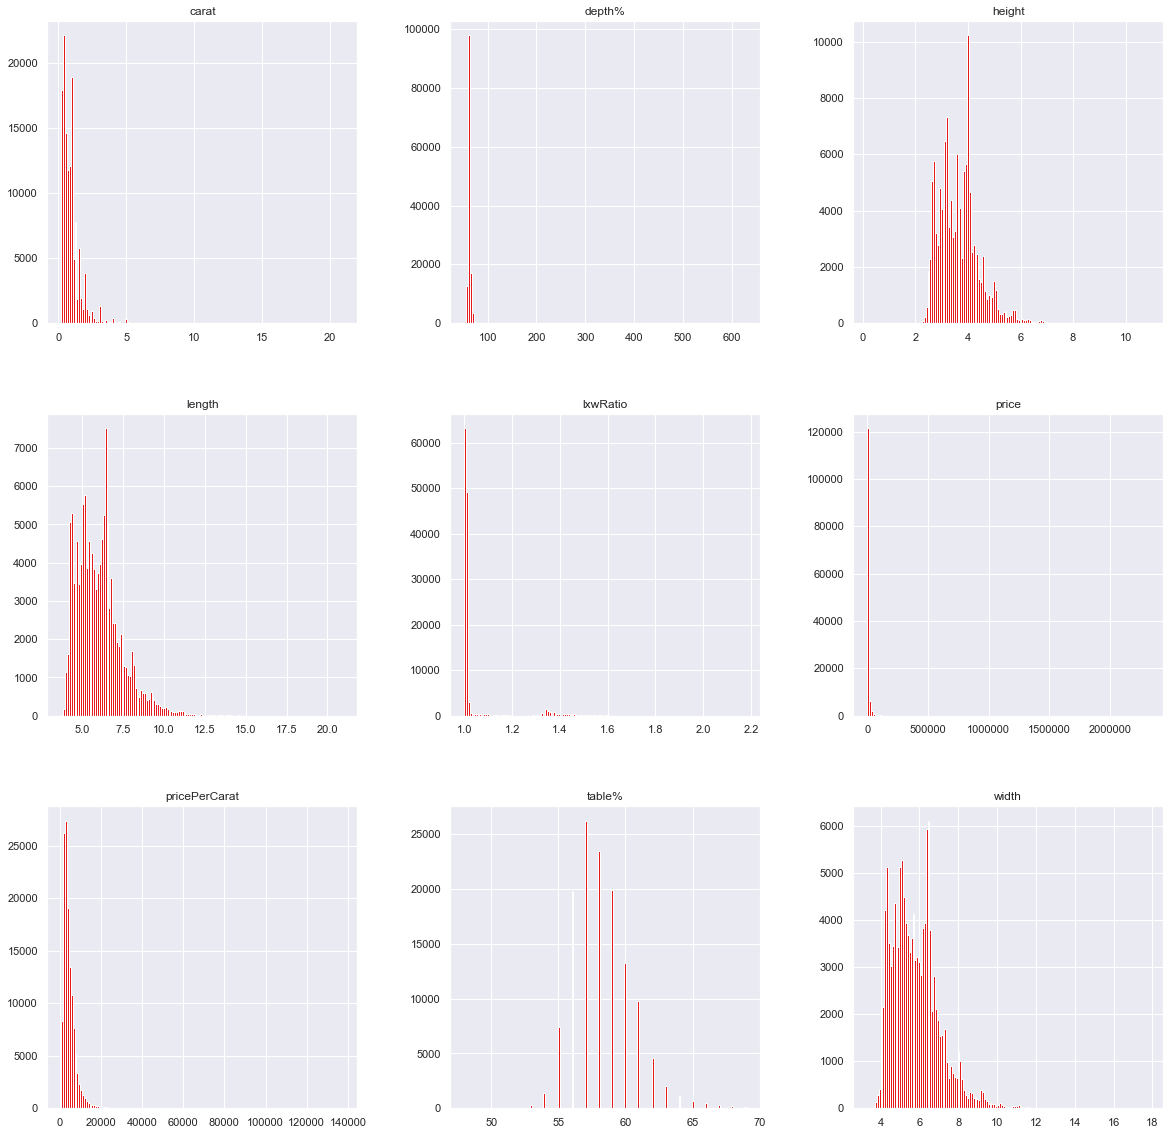

In [171]:
p = diamond_df.hist(figsize = (20,20),bins=150)

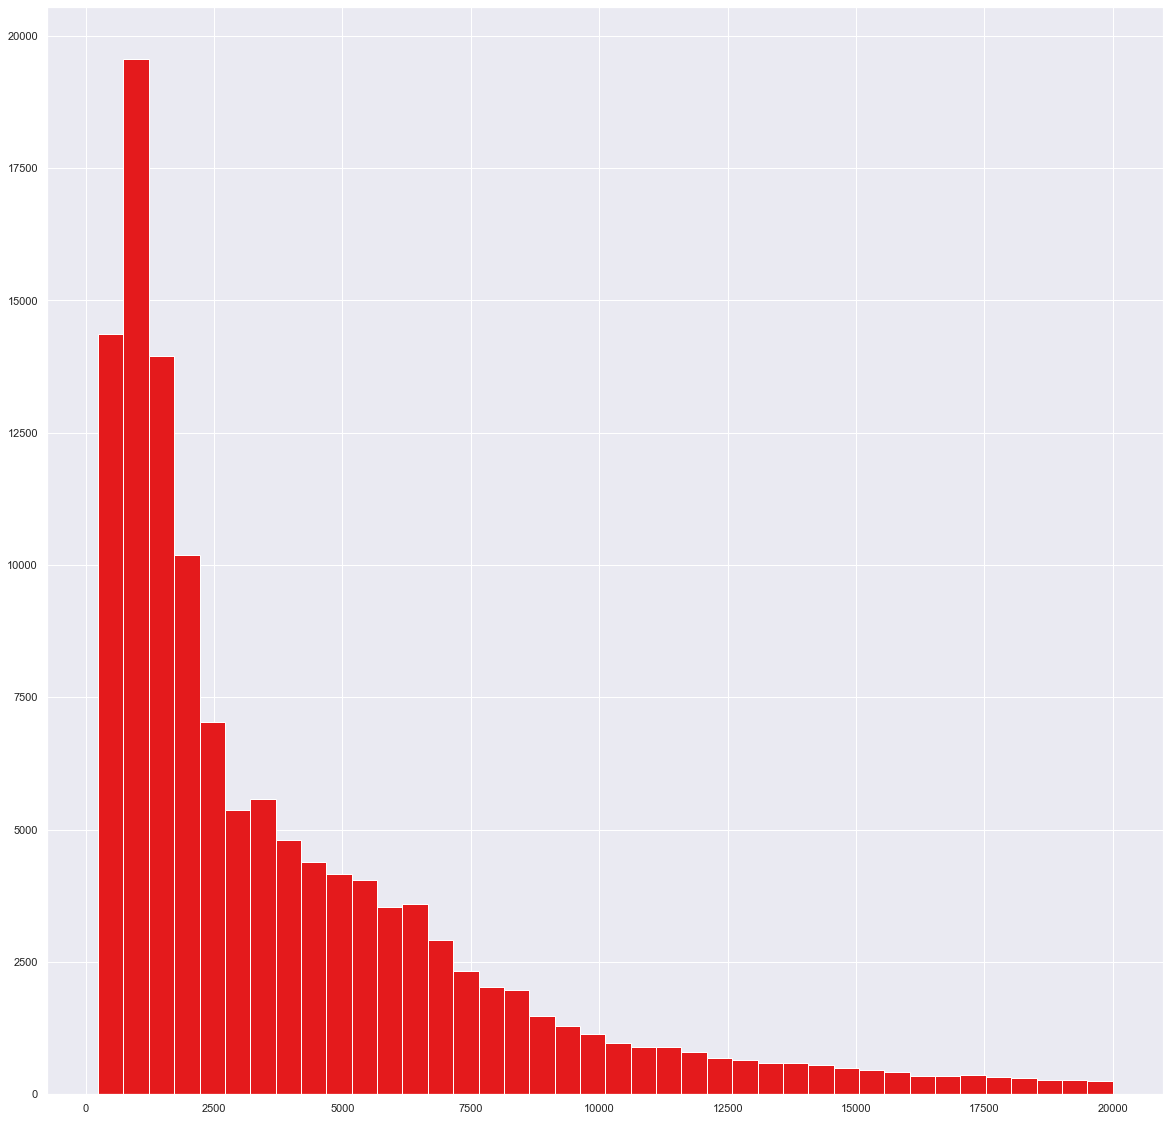

In [212]:
p = diamond_df['price'][diamond_df['price'] < 20000].hist(figsize = (20,20),bins=40)

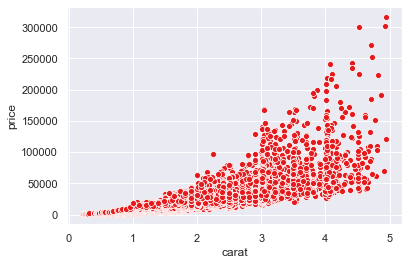

In [213]:
p=sns.scatterplot(x='carat', y='price', data=diamond_df[(diamond_df['shapeName'] == 'Round')
                                                        & (diamond_df['carat'] < 5)])

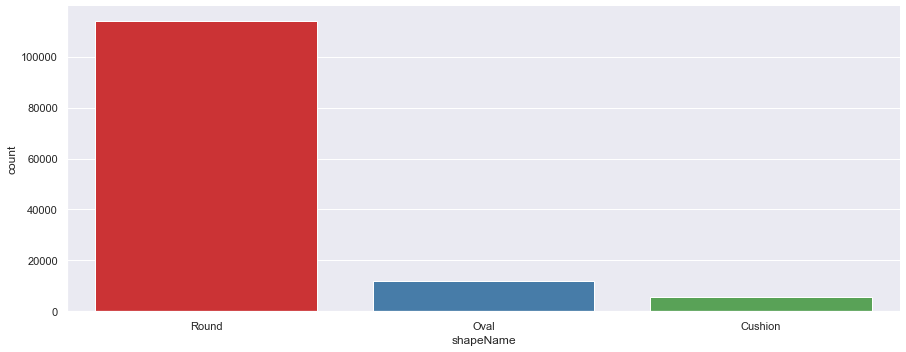

In [172]:
p = sns.factorplot(x='shapeName', data=diamond_df , kind='count',aspect=2.5 )

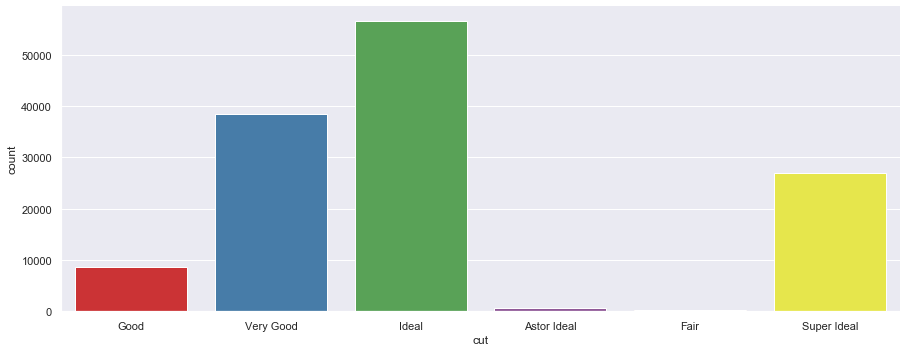

In [173]:
p = sns.factorplot(x='cut', data=diamond_df , kind='count',aspect=2.5 )

In [201]:
diamond_df['cut'] = diamond_df['cut'].str.replace('Astor Ideal', 'Super Ideal')

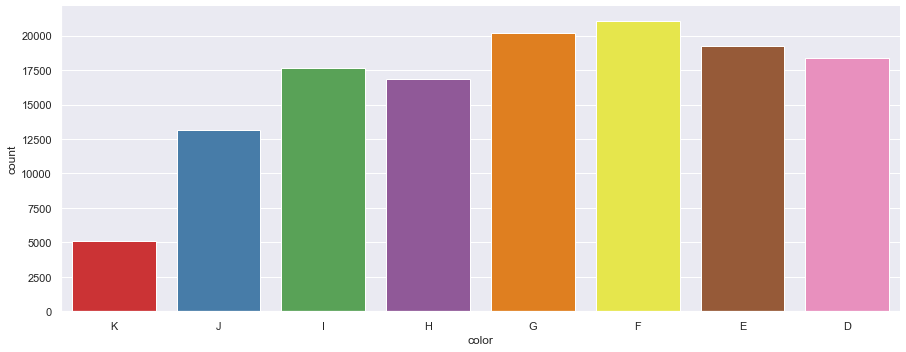

In [174]:
p = sns.factorplot(x='color', data=diamond_df , kind='count',aspect=2.5 )

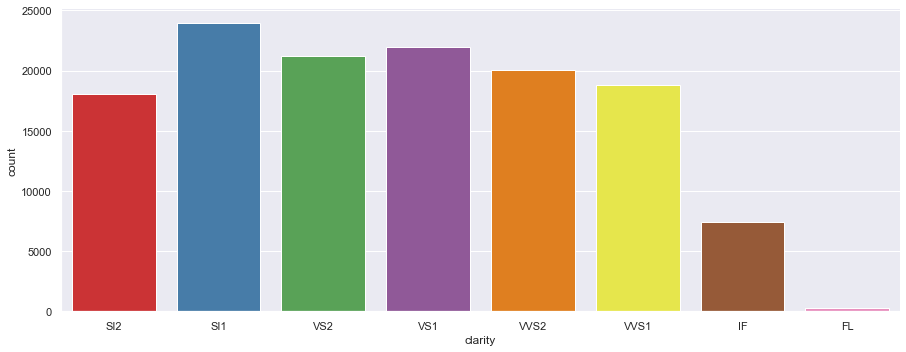

In [175]:
p = sns.factorplot(x='clarity', data=diamond_df , kind='count',aspect=2.5 )

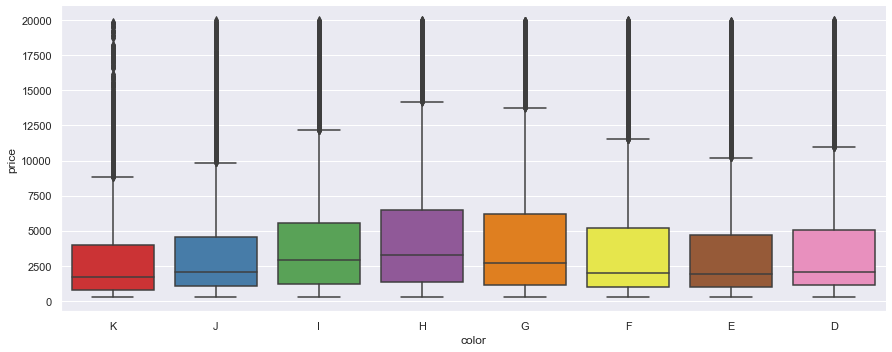

In [176]:
p = sns.factorplot(x='color', 
                   y='price', 
                   data=diamond_df[(diamond_df['shapeName'] == 'Round') 
                                   & (diamond_df['carat'] < 5)
                                   & (diamond_df['price'] < 20000)], 
                                   kind='box',
                                   aspect=2.5)

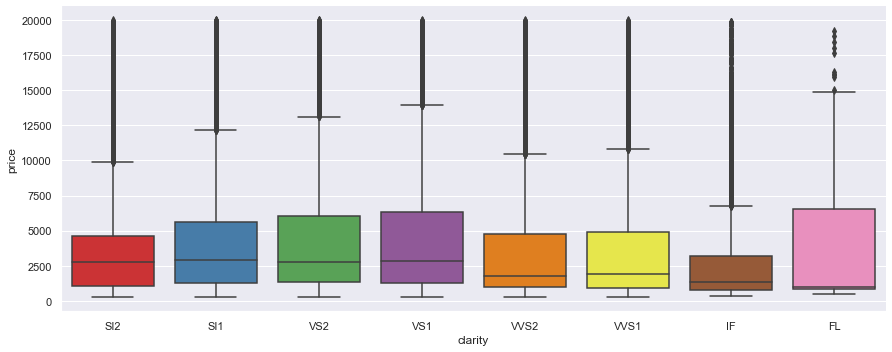

Executing shutdown due to inactivity...
Executing shutdown due to inactivity...


2020-06-13 15:33:22,947 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...
Executing shutdown...


2020-06-13 15:33:27,024 - INFO     - Executing shutdown...


In [177]:
p = sns.factorplot(x='clarity', 
                   y='price', 
                   data=diamond_df[(diamond_df['shapeName'] == 'Round') 
                                   & (diamond_df['carat'] < 5)
                                   & (diamond_df['price'] < 20000)], 
                                   kind='box',
                                   aspect=2.5)

In [285]:
diamond_df_temp = diamond_df.dropna()
botswana = diamond_df_temp[diamond_df_temp['origin'].str.contains('Botswana Sort')]
russia = diamond_df_temp[diamond_df_temp['origin'].str.contains('Russia')]
recycled = diamond_df_temp[diamond_df_temp['origin'].str.contains('Recycled')]
canada = diamond_df_temp[diamond_df_temp['origin'].str.contains('Canada')]

In [289]:
canada.describe()

,carat,price,pricePerCarat,depth%,lxwRatio,table%,length,width,height
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
diamond_df_filtered = diamond_df[['carat', 'price', 'shapeName', 'clarity',
                                  'color', 'culet', 'cut', 'fluorescence', 'polish', 'symmetry']]
diamond_df_filtered = diamond_df_filtered[diamond_df_filtered['shapeName'].str.contains('Round')]
diamond_df_filtered = diamond_df_filtered.drop(['shapeName'],axis=1)
diamond_df_filtered.dropna(inplace=True)

In [374]:
diamond_df_filtered['culet'].unique()

array(['None', 'Small', 'Very Small', 'Medium', 'Pointed', 'A', 'SL',
       'SMALL FACETED', 'Nonee', 'NATURAL', 'POLISHED', 'S. FACETED',
       ' Faceted'], dtype=object)

In [375]:
print("Number of rows with Pointed in culet column: {} ".format((diamond_df_filtered['culet'].str.contains('Pointed')).sum()))
print("Number of rows with SL in culet column: {} ".format((diamond_df_filtered['culet'].str.contains('SL')).sum()))
print("Number of rows with A in culet column: {} ".format((diamond_df_filtered['culet'].str.contains('A')).sum()))
print("Number of rows with NATURAL in culet column: {} ".format((diamond_df_filtered['culet'].str.contains('NATURAL')).sum()))
print("Number of rows with POLISHED in culet column: {} ".format((diamond_df_filtered['culet'].str.contains('POLISHED')).sum()))
print("Number of rows with Faceted in culet column: {} ".format((diamond_df_filtered['culet'].str.contains('Faceted')).sum()))


Number of rows with Pointed in culet column: 2605 
Number of rows with SL in culet column: 10 
Number of rows with A in culet column: 31 
Number of rows with NATURAL in culet column: 3 
Number of rows with POLISHED in culet column: 1 
Number of rows with Faceted in culet column: 1 


In [376]:
diamond_df_filtered['culet'] = diamond_df_filtered['culet'].str.replace('Nonee', 'None')
diamond_df_filtered['culet'] = diamond_df_filtered['culet'].str.replace('Pointed', 'None')
diamond_df_filtered['culet'] = diamond_df_filtered['culet'].str.replace('SL', 'Slightly Large')
diamond_df_filtered = diamond_df_filtered[~diamond_df_filtered['culet'].isin(['A', 'SMALL FACETED','NATURAL', 'POLISHED', 'S. FACETED', ' Faceted'])]
diamond_df_filtered['culet'].unique()

array(['None', 'Small', 'Very Small', 'Medium', 'Slightly Large'],
      dtype=object)

In [377]:
diamond_df_filtered['fluorescence'].unique()

array(['Strong', 'None', 'Medium', 'Faint', 'Medium Blue', 'Strong Blue',
       'Very Strong Blue', 'Very Strong', 'Medium Yellow',
       'Strong Yellow', 'Slight', 'Very Slight'], dtype=object)

In [378]:
diamond_df_filtered['fluorescence'] = diamond_df_filtered['fluorescence'].str.replace('Very Slight', 'Faint')
diamond_df_filtered['fluorescence'] = diamond_df_filtered['fluorescence'].str.strip(' Blue')
diamond_df_filtered['fluorescence'] = diamond_df_filtered['fluorescence'].str.strip(' Yellow')
diamond_df_filtered['fluorescence'] = diamond_df_filtered['fluorescence'].str.replace('Non', 'None')
diamond_df_filtered['fluorescence'].unique()

array(['Strong', 'None', 'Medium', 'Faint', 'Very Strong', 'Slight'],
      dtype=object)

In [379]:
diamond_df_filtered['polish'].unique()

array(['Excellent', 'Good', 'Very Good', 'Fair'], dtype=object)

In [380]:
diamond_df_filtered['symmetry'].unique()

array(['Very Good', 'Good', 'Excellent', 'Fair'], dtype=object)

In [381]:
culet_order = ['Slightly Large', 'Medium', 'Small', 'Very Small', 'None']
fluorescence_order = ['Very Strong', 'Strong', 'Medium', 'Slight', 'Faint', 'None']
polish_order = ['Fair', 'Good', 'Very Good', 'Excellent']
symmetry_order = ['Fair', 'Good', 'Very Good', 'Excellent']
cut_order = ['Fair', 'Good', 'Very Good', 'Ideal', 'Super Ideal']
color_order = ['K', 'J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL']
ordinal_cols = ['culet', 'fluorescence', 'polish', 'symmetry', 'cut', 'color', 'clarity']
ordinal_orders = [culet_order, fluorescence_order, polish_order, symmetry_order, cut_order, 
                 color_order, clarity_order]

In [382]:
diamond_df_filtered.head()

,carat,price,clarity,color,culet,cut,fluorescence,polish,symmetry
0,5.01,42001.0,SI2,K,None,Good,Strong,Excellent,Very Good
1,4.63,41019.0,SI2,K,Small,Good,Strong,Good,Good
2,2.01,7731.0,SI2,K,None,Good,None,Very Good,Very Good
3,1.65,6755.0,SI2,K,Very Small,Good,Medium,Good,Good
4,1.67,6156.0,SI2,K,None,Good,Medium,Very Good,Very Good


In [383]:
ordinal_encoding = zip(ordinal_cols, ordinal_orders)
for col, order in ordinal_encoding:
    cat = pd.Categorical(diamond_df_filtered[col],
                        categories=order,
                        ordered=True)
    labels, unique = pd.factorize(cat, sort=True)
    diamond_df_filtered[col] = labels

In [385]:
diamond_df_filtered.head()

,carat,price,clarity,color,culet,cut,fluorescence,polish,symmetry
0,5.01,42001.0,0,0,4,1,1,3,2
1,4.63,41019.0,0,0,2,1,1,1,1
2,2.01,7731.0,0,0,4,1,5,2,2
3,1.65,6755.0,0,0,3,1,2,1,1
4,1.67,6156.0,0,0,4,1,2,2,2


In [386]:
diamond_df_encoded = diamond_df_filtered.copy()

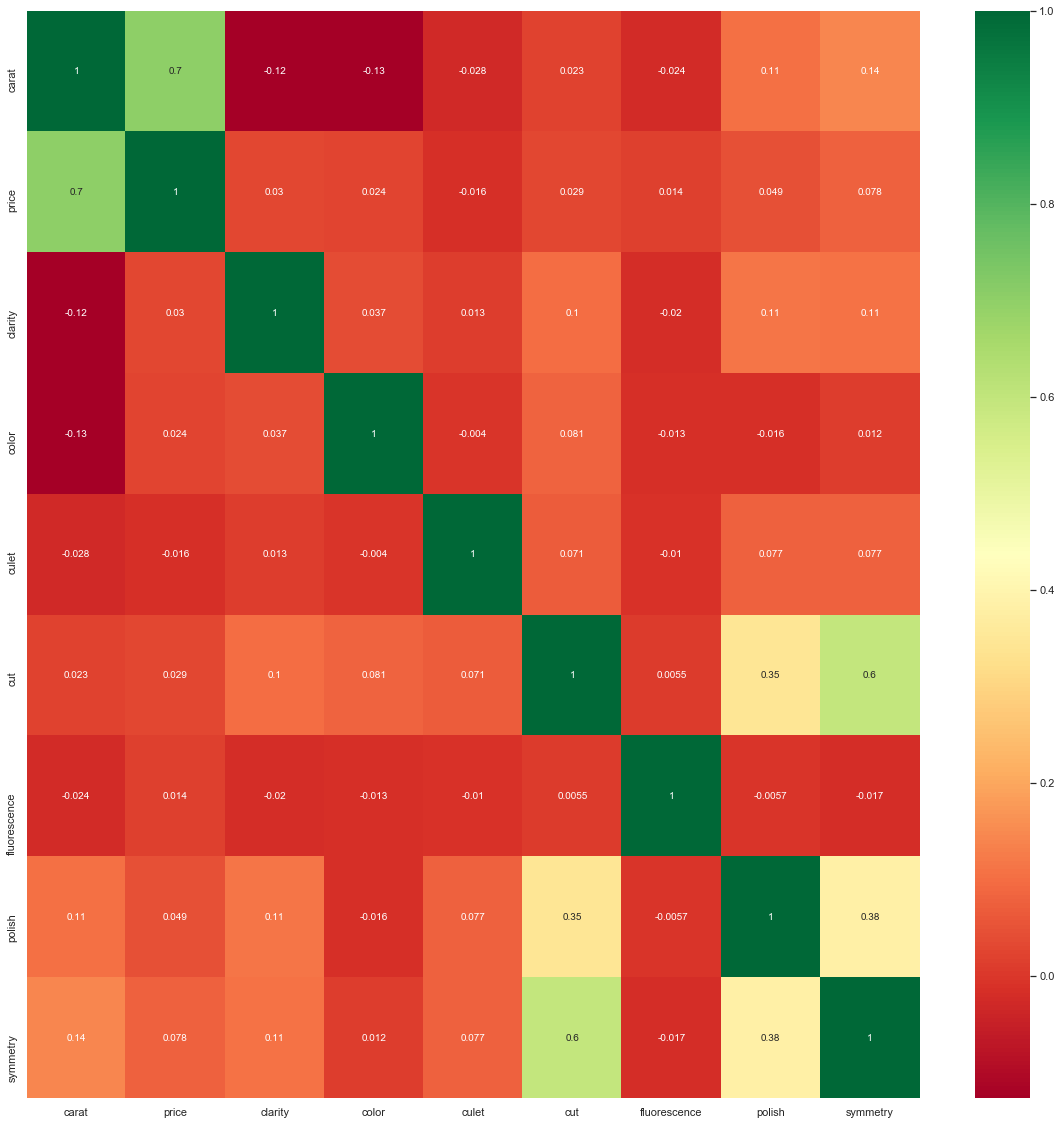

In [387]:
plt.figure(figsize=(20,20))
p=sns.heatmap(diamond_df_encoded.corr(), annot=True,cmap='RdYlGn')

In [388]:
X = diamond_df_encoded.drop(['price'],axis=1)
y = diamond_df_encoded['price']

In [389]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [390]:
clf_lr = LinearRegression()
clf_lr.fit(X_train , y_train)
accuracies = cross_val_score(estimator = clf_lr, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = clf_lr.predict(X_test)
print('')
print('####### Linear Regression #######')
print('Score : %.4f' % clf_lr.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)



####### Linear Regression #######
Score : 0.5496
[0.53394173 0.58486161 0.517088   0.46904758 0.5367253 ]

MSE    : 172350758.86 
MAE    : 5574.70 
RMSE   : 13128.24 
R2     : 0.55 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [401]:
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train , y_train)
accuracies = cross_val_score(estimator = clf_rf, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = clf_rf.predict(X_test)
print('')
print('###### Random Forest ######')
print('Score : %.4f' % clf_rf.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('MAPE   : %0.2f ' % mape)
print('R2     : %0.2f ' % r2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished



###### Random Forest ######
Score : 0.9448
[0.98128471 0.9559787  0.90917414 0.91351711 0.92046436]

MSE    : 21128126.06 
MAE    : 601.88 
RMSE   : 4596.53 
MAPE   : 8.96 
R2     : 0.94 


In [402]:
# carat clarity color culet cut fluorescence polish symmetry
# clarity_order = ['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL']
# color_order = ['K', 'J', 'I', 'H', 'G', 'F', 'E', 'D']
# culet_order = ['Slightly Large', 'Medium', 'Small', 'Very Small', 'None']
# cut_order = ['Fair', 'Good', 'Very Good', 'Ideal', 'Super Ideal']
# fluorescence_order = ['Very Strong', 'Strong', 'Medium', 'Slight', 'Faint', 'None']
# polish_order = ['Fair', 'Good', 'Very Good', 'Excellent']
# symmetry_order = ['Fair', 'Good', 'Very Good', 'Excellent']


Xnew = [[.4, clarity_order.index('VS2'), 
         color_order.index('G'), 
         culet_order.index('Very Small'), 
         cut_order.index('Very Good'), 
         fluorescence_order.index('Faint'), 
         polish_order.index('Very Good'), 
         symmetry_order.index('Very Good')]]

# make a prediction
ynew = clf_rf.predict(Xnew)
print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

X=[0.4, 2, 4, 3, 2, 4, 2, 2], Predicted=854.9747142857145
